# T81-558: Applications of Deep Neural Networks
**Module 14: Other Neural Network Techniques**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 14 Video Material

* Part 14.1: What is AutoML [[Video]](https://www.youtube.com/watch?v=TFUysIR5AB0&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_14_01_automl.ipynb)
* **Part 14.2: Using Denoising AutoEncoders in Keras** [[Video]](https://www.youtube.com/watch?v=4bTSu6_fucc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_14_02_auto_encode.ipynb)
* Part 14.3: Training an Intrusion Detection System with KDD99 [[Video]](https://www.youtube.com/watch?v=1ySn6h2A68I&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_14_03_anomaly.ipynb)
* Part 14.4: Anomaly Detection in Keras [[Video]](https://www.youtube.com/watch?v=VgyKQ5MTDFc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_14_04_ids_kdd99.ipynb)
* Part 14.5: The Deep Learning Technologies I am Excited About [[Video]]() [[Notebook]](t81_558_class_14_05_new_tech.ipynb)



# Part 14.2: Using Denoising AutoEncoders in Keras

# Function Approximation


In [12]:
# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

Actual
[[0.00071864]
 [0.01803382]
 [0.11465593]
 [0.1213861 ]
 [0.1712333 ]]
Pred
[[0.00317574]
 [0.02026811]
 [0.11543235]
 [0.12497211]
 [0.19133109]]


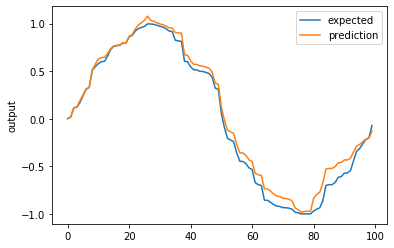

In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

rng = np.random.RandomState(1)
x = np.sort((360 * rng.rand(100, 1)), axis=0)
y = np.array([np.sin(x*(np.pi/180.0)).ravel()]).T

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,y,verbose=0,batch_size=len(x),epochs=25000)

pred = model.predict(x)

print("Actual")
print(y[0:5])

print("Pred")
print(pred[0:5])

chart_regression(pred.flatten(),y,sort=False)

# Multi-Output Regression

Unlike most models, neural networks can provide multiple regression outputs.  This allows a neural network to generate multiple outputs for the same input.  For example, the MPG data set might be trained to predict both MPG and horsepower.  One area that multiple regression outputs can be useful for is auto encoders.  The following diagram shows a multi-regression neural network.  As you can see, there are multiple output neurons.  Usually multiple output neurons are used for classification.  However, in this case it is a regression neural network.

![Multi-Output Regression](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_13_multi_output.png "Multi-Output Regression")

The following program uses a multi-output regression to predict both [sin](https://en.wikipedia.org/wiki/Trigonometric_functions#Sine.2C_cosine_and_tangent) and [cos](https://en.wikipedia.org/wiki/Trigonometric_functions#Sine.2C_cosine_and_tangent) from the same input data.

In [14]:
from sklearn import metrics

rng = np.random.RandomState(1)
x = np.sort((360 * rng.rand(100, 1)), axis=0)
y = np.array([np.pi * np.sin(x*(np.pi/180.0)).ravel(), np.pi * np.cos(x*(np.pi/180.0)).ravel()]).T

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(2)) # Two output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,y,verbose=0,batch_size=len(x),epochs=25000)


# Fit regression DNN model.
pred = model.predict(x)

score = np.sqrt(metrics.mean_squared_error(pred, y))
print("Score (RMSE): {}".format(score))

np.set_printoptions(suppress=True)

print("Predicted:")
print(np.array(pred[20:25]))

print("Expected:")
print(np.array(y[20:25]))

Score (RMSE): 0.0607553517426597
Predicted:
[[2.6972563  1.5949173 ]
 [2.7385583  1.5186492 ]
 [2.884924   1.2355493 ]
 [2.9632306  1.0122485 ]
 [3.0012193  0.88598156]]
Expected:
[[2.70765313 1.59317888]
 [2.75138445 1.51640628]
 [2.89299999 1.22480835]
 [2.97603942 1.00637655]
 [3.01381723 0.88685404]]


# Simple Auto Encoder

An auto encoder is a neural network that has the same number of input neurons as it does outputs.  The hidden layers of the neural network will have fewer neurons than the input/output neurons.  Because there are fewer neurons, the auto-encoder must learn to encode the input to the fewer hidden neurons.  The predictors (x) and output (y) are exactly the same in an auto encoder.  Because of this, auto encoders are said to be unsupervised.  

![Simple Auto Encoder](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_13_auto_encode.png "Simple Auto Encoder")

The following program demonstrates a very simple auto encoder that learns to encode a sequence of numbers.  Fewer hidden neurons will make it much more difficult for the auto encoder to learn.

In [15]:
from sklearn import metrics
import numpy as np
import pandas as pd
from IPython.display import display, HTML 
import tensorflow as tf

x = np.array([range(10)]).astype(np.float32)
print(x)

model = Sequential()
model.add(Dense(3, input_dim=x.shape[1], activation='relu'))
model.add(Dense(x.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,x,verbose=0,epochs=1000)

pred = model.predict(x)
score = np.sqrt(metrics.mean_squared_error(pred,x))
print("Score (RMSE): {}".format(score))
np.set_printoptions(suppress=True)
print(pred)

[[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]]
Score (RMSE): 0.8473137021064758
[[0.0133801 1.153795  2.0281403 3.0298407 4.1182265 5.0704904 6.360253
  7.321521  8.555862  6.4323545]]


# Auto Encode (single image)

We are now ready to build a simple image auto encoder.  The program below learns an effective encoding for the image.  You can see the distortions that occur.

49152
[[ 84. 134. 177. ...   6.  15.  14.]]
Neural network output
[[114.38295   124.415985  103.903145  ...  11.447948    4.4970107
   19.995102 ]]
[[ 84. 134. 177. ...   6.  15.  14.]]


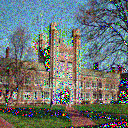

In [16]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
from tensorflow.keras.optimizers import SGD
import requests
from io import BytesIO

url = "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg"
    
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()
img = img.resize((128,128), Image.ANTIALIAS)
img_array = np.asarray(img)
img_array = img_array.flatten()
img_array = np.array([ img_array ])
img_array = img_array.astype(np.float32)
print(img_array.shape[1])
print(img_array)

model = Sequential()
model.add(Dense(10, input_dim=img_array.shape[1], activation='relu'))
model.add(Dense(img_array.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(img_array,img_array,verbose=0,epochs=20)

print("Neural network output")
pred = model.predict(img_array)
print(pred)
print(img_array)
cols,rows = img.size
img_array2 = pred[0].reshape(rows,cols,3)
img_array2 = img_array2.astype(np.uint8)
img2 = Image.fromarray(img_array2, 'RGB')
img2   

# Standardize Images

When processing several images together it is sometimes important to standardize them.  The following code reads a sequence of images and causes them to all be of the same size and perfectly square.  If the input images are not square, cropping will occur.

https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg


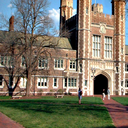

https://upload.wikimedia.org/wikipedia/commons/f/ff/WashU_Graham_Chapel.JPG


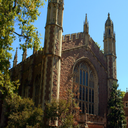

https://upload.wikimedia.org/wikipedia/commons/9/9e/SeigleHall.jpg


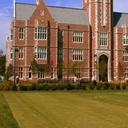

https://upload.wikimedia.org/wikipedia/commons/a/aa/WUSTLKnight.jpg


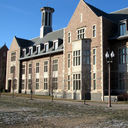

https://upload.wikimedia.org/wikipedia/commons/3/32/WashUABhall.jpg


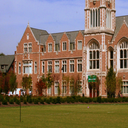

https://upload.wikimedia.org/wikipedia/commons/c/c0/Brown_Hall.jpg


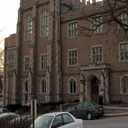

https://upload.wikimedia.org/wikipedia/commons/f/f4/South40.jpg


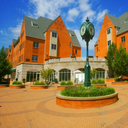

(7, 49152)


In [17]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML

#url = "http://www.heatonresearch.com/images/about-jeff.jpg"

images = [
    "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/ff/WashU_Graham_Chapel.JPG",
    "https://upload.wikimedia.org/wikipedia/commons/9/9e/SeigleHall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/a/aa/WUSTLKnight.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/3/32/WashUABhall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/c/c0/Brown_Hall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/f4/South40.jpg"    
]


def make_square(img):
    cols,rows = img.size
    
    if rows>cols:
        pad = (rows-cols)/2
        img = img.crop((pad,0,cols,cols))
    else:
        pad = (cols-rows)/2
        img = img.crop((0,pad,rows,rows))
    
    return img
    
x = [] 
    
for url in images:
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.load()
    img = make_square(img)
    img = img.resize((128,128), Image.ANTIALIAS)
    print(url)
    display(img)
    img_array = np.asarray(img)
    img_array = img_array.flatten()
    img_array = img_array.astype(np.float32)
    img_array = (img_array-128)/128
    x.append(img_array)
    

x = np.array(x)

print(x.shape)


# Image Auto Encoder (multi-image)

Auto encoders can learn the same encoding for multiple images.  The following code learns a single encoding for multiple images. 

Creating/Training neural network
Score neural network
[-0.14099729  0.2504178   0.58697623 ... -0.80495536 -0.8600077
 -0.7507377 ]


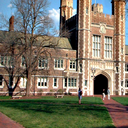

[ 0.1245165   0.05581025 -0.9469281  ... -0.5964093  -0.77362233
 -0.87149537]


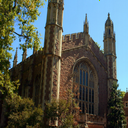

[-0.16287911  0.07083478  0.8028359  ...  0.15529267 -0.1485157
 -0.63872755]


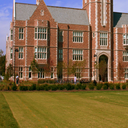

[-0.40565515  0.08525646  0.6543999  ... -0.12393776 -0.22541034
 -0.34251797]


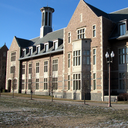

[ 0.28899017  0.38252142  0.7866407  ... -0.2032861  -0.2651671
 -0.82580376]


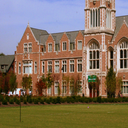

[ 0.9917432   0.9890273   0.982688   ... -0.18442157 -0.204146
 -0.20103177]


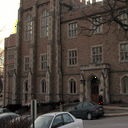

[-0.78713    -0.38974318  0.52933806 ...  0.6468072   0.20250452
 -0.35054564]


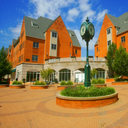

In [18]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
from sklearn import metrics
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display, HTML 

# Fit regression DNN model.
print("Creating/Training neural network")
model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='relu'))
model.add(Dense(x.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,x,verbose=0,epochs=1000)

print("Score neural network")
pred = model.predict(x)

cols,rows = img.size
for i in range(len(pred)):
    print(pred[i])
    img_array2 = pred[i].reshape(rows,cols,3)
    img_array2 = (img_array2*128)+128
    img_array2 = img_array2.astype(np.uint8)
    img2 = Image.fromarray(img_array2, 'RGB')
    display(img2)   

# Adding Noise to an Image

Auto encoders can handle noise.  First it is important to see how to add noise to an image.  There are many ways to add such noise.  The following code adds random black squares to the image to produce noise.

Rows: 744, Cols: 1157
(744, 1157, 3)


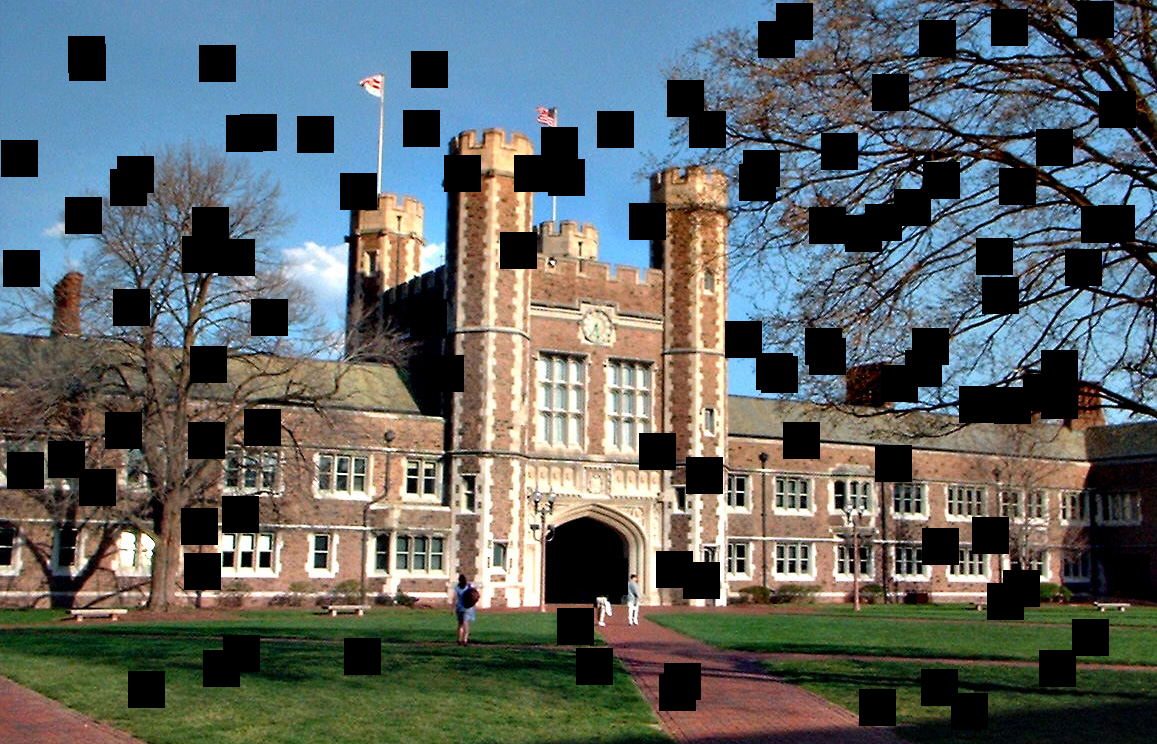

In [19]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO

%matplotlib inline


def add_noise(a):
    a2 = a.copy()
    rows = a2.shape[0]
    cols = a2.shape[1]
    s = int(min(rows,cols)/20) # size of spot is 1/20 of smallest dimension
    
    for i in range(100):
        x = np.random.randint(cols-s)
        y = np.random.randint(rows-s)
        a2[y:(y+s),x:(x+s)] = 0
        
    return a2

url = "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg"
#url = "http://www.heatonresearch.com/images/about-jeff.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

img_array = np.asarray(img)
rows = img_array.shape[0]
cols = img_array.shape[1]

print("Rows: {}, Cols: {}".format(rows,cols))

# Create new image
img2_array = img_array.astype(np.uint8)
print(img2_array.shape)
img2_array = add_noise(img2_array)
img2 = Image.fromarray(img2_array, 'RGB')
img2        
        

# Denoising Autoencoder

A denoising auto encoder is designed to remove noise from input signals.  To do this the $y$ becomes each image/signal (just like a normal auto encoder), however, the $x$ becomes a version of $y$ with noise added.  Noise is artificially added to the images to produce $x$.  The following code creates 10 noisy version of each of the images.  The network is trained to convert noisy data ($x$) to the origional input ($y$).

https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg


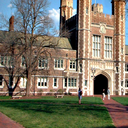

https://upload.wikimedia.org/wikipedia/commons/f/ff/WashU_Graham_Chapel.JPG


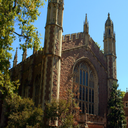

https://upload.wikimedia.org/wikipedia/commons/9/9e/SeigleHall.jpg


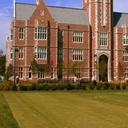

https://upload.wikimedia.org/wikipedia/commons/a/aa/WUSTLKnight.jpg


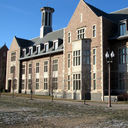

https://upload.wikimedia.org/wikipedia/commons/3/32/WashUABhall.jpg


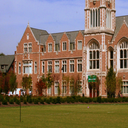

https://upload.wikimedia.org/wikipedia/commons/c/c0/Brown_Hall.jpg


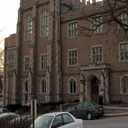

https://upload.wikimedia.org/wikipedia/commons/f/f4/South40.jpg


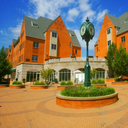

(70, 49152)
(70, 49152)


In [20]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML

#url = "http://www.heatonresearch.com/images/about-jeff.jpg"

images = [
    "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/ff/WashU_Graham_Chapel.JPG",
    "https://upload.wikimedia.org/wikipedia/commons/9/9e/SeigleHall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/a/aa/WUSTLKnight.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/3/32/WashUABhall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/c/c0/Brown_Hall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/f4/South40.jpg"    
]


def make_square(img):
    cols,rows = img.size
    
    if rows>cols:
        pad = (rows-cols)/2
        img = img.crop((pad,0,cols,cols))
    else:
        pad = (cols-rows)/2
        img = img.crop((0,pad,rows,rows))
    
    return img
    
x = []    
y = []
loaded_images = []
    
for url in images:
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.load()
    img = make_square(img)
    img = img.resize((128,128), Image.ANTIALIAS)
    
    loaded_images.append(img)
    print(url)
    display(img)
    for i in range(10):
        img_array = np.asarray(img)
        img_array_noise = add_noise(img_array)
        
        img_array = img_array.flatten()
        img_array = img_array.astype(np.float32)
        img_array = (img_array-128)/128
        
        img_array_noise = img_array_noise.flatten()
        img_array_noise = img_array_noise.astype(np.float32)
        img_array_noise = (img_array_noise-128)/128
        
        x.append(img_array_noise)
        y.append(img_array)
    
x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)


In [21]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
from sklearn import metrics
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display, HTML 

# Fit regression DNN model.
print("Creating/Training neural network")
model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(x.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,y,verbose=1,epochs=20)

print("Neural network trained")


Creating/Training neural network
Train on 70 samples
Epoch 1/20
70/70 [==============================] - 0s 5ms/sample - loss: 0.2747
Epoch 2/20
70/70 [==============================] - 0s 3ms/sample - loss: 0.2006
Epoch 3/20
70/70 [==============================] - 0s 3ms/sample - loss: 0.1687
Epoch 4/20
70/70 [==============================] - 0s 3ms/sample - loss: 0.1522
Epoch 5/20
70/70 [==============================] - 0s 3ms/sample - loss: 0.1279
Epoch 6/20
70/70 [==============================] - 0s 3ms/sample - loss: 0.1066
Epoch 7/20
70/70 [==============================] - 0s 3ms/sample - loss: 0.0826
Epoch 8/20
70/70 [==============================] - 0s 3ms/sample - loss: 0.0571
Epoch 9/20
70/70 [==============================] - 0s 3ms/sample - loss: 0.0366
Epoch 10/20
70/70 [==============================] - 0s 3ms/sample - loss: 0.0241
Epoch 11/20
70/70 [==============================] - 0s 3ms/sample - loss: 0.0177
Epoch 12/20
70/70 [==============================] - 0

*** Trial 1
With noise:


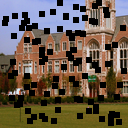

After auto encode noise removal


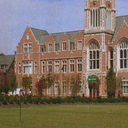

*** Trial 2
With noise:


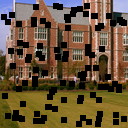

After auto encode noise removal


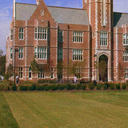

*** Trial 3
With noise:


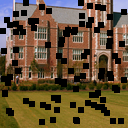

After auto encode noise removal


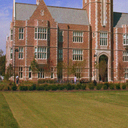

*** Trial 4
With noise:


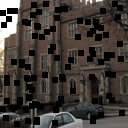

After auto encode noise removal


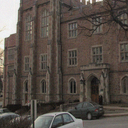

*** Trial 5
With noise:


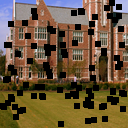

After auto encode noise removal


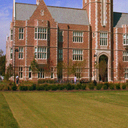

*** Trial 6
With noise:


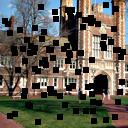

After auto encode noise removal


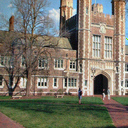

*** Trial 7
With noise:


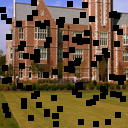

After auto encode noise removal


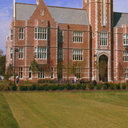

*** Trial 8
With noise:


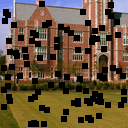

After auto encode noise removal


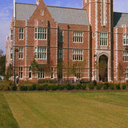

*** Trial 9
With noise:


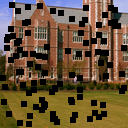

After auto encode noise removal


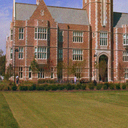

*** Trial 10
With noise:


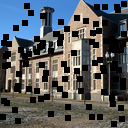

After auto encode noise removal


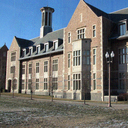

In [22]:
for z in range(10):
    print("*** Trial {}".format(z+1))
    
    # Choose random image
    i = np.random.randint(len(loaded_images))
    img = loaded_images[i]
    img_array = np.asarray(img)
    cols, rows = img.size

    # Add noise
    img_array_noise = add_noise(img_array)    

    #Display noisy image
    img2 = img_array_noise.astype(np.uint8)
    img2 = Image.fromarray(img2, 'RGB')
    print("With noise:")
    display(img2)

    # Present noisy image to auto encoder
    img_array_noise = img_array_noise.flatten()
    img_array_noise = img_array_noise.astype(np.float32)
    img_array_noise = (img_array_noise-128)/128
    img_array_noise = np.array([img_array_noise])
    pred = model.predict(img_array_noise)[0]

    # Display neural result
    img_array2 = pred.reshape(rows,cols,3)
    img_array2 = (img_array2*128)+128
    img_array2 = img_array2.astype(np.uint8)
    img2 = Image.fromarray(img_array2, 'RGB')
    print("After auto encode noise removal")
    display(img2)